# Facies classification using Machine Learning
#### Brendon Hall, [Enthought](https://www.enthought.com/)
2016 SEG Machine Learning Competition  
Transcribed and translated by Joshua Poirier, [NEOS](https://www.neosgeo.com/)

## Introduction

This notebook is intended to reproduce the results of Brendon Hall's "Facies classification using Machine Learning" notebook.  Hall's notebook was coded using the Python programming language; whereas here, I will use the R programming language.  Differences in the exact results can be expected as the back-end implementations of libraries each respective notebook calls can differ, along with different random number seeding.  Given the intent to reproduce Hall's notebook, much of the annotating markdown cells contain moreorless the same text.  

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we use comes from a class exercise from The University of Kansas on Neural Networks and Fuzzy Systems.  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields.  

The dataset we will use is log data from nine wells that have been labeled with a facies type based on core observation.  We will use this log data to train a Support Vector Machine (SVM) to classify facies types.  SVM's are a type of supervised learning model that can be trained on datato perform classification and regression tasks.  The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (in our case - facies).  We will implement an SVM model using a combination of the **e1071** and **caret** R packages.  

We will first explore the dataset by loading data from 9 wells - examining the data via well log plots and cross plots.  We will split the data into training, cross-validation, and blind test data sets and condition the data such that each feature has zero mean and unit variance.  The training data will then be used to build an initial SVM classifier.  The cross-validation data will be used to optimize the SVM parameters.  The blind test data will also be used to evaluate the quality of the cross-validated model.  Finally, we will apply the trained model to classify facies for two wells which do not already have facies labels.

First, let's load all of the R packages we will be using during this data analysis.

In [119]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)
library(GGally)

# machine learning packages
library(caret)
library(e1071)

## Exploring the dataset  

First let's examine the data set we will use to train, cross-validate, and test the classifier.  The training data is contained in the file *facies_vectors.csv*.  The dataset consists of five wireline log measurements, two indicator variables and a facies label at half-foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).

In [6]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# display first five rows of data set and it's dimensions
head(data)
paste(dim(data)[1], "rows x", dim(data)[2], "columns")

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894


[1] "4149 rows x 11 columns"

Now let's remove a single well to function as our blind test data set.  We will use the **Newby** well as the blind test.  Later we will split the remaining data into training and cross-validation data.

In [7]:
# training and validation maybe?
blind <- data[data$Well.Name == 'NEWBY',]
data <- data[data$Well.Name != 'NEWBY',]

This data is from the Panoma Council Grove Field (predominantly gas reservoir) over 2700 sq mi in SW Kansas.  The dataset is from nine wells with 4149 samples.  Each sample consists of seven predictor variables and a rock facies.  The validation (test) data have 830 samples from two wells having the same seven predictor variables.  Facies are based on examination of cores from the nine wells taken vertically at half-foot intervals.  The predictor variables include five wireline log measurements and two geologic constraining variables that are derived from geologic knowledge and are sampled at the same half-foot rate.  

The seven predictor variables are:

* GR - Gamma ray  
* ILD_log10 - Resistivity logging  
* PE - Photoelectric effect (some wells are missing this log)  
* DeltaPhi - Neutron-density porosity difference  
* PHIND - Average neutron-density porosity  

The two geologic constraining variables are:  

* NM_M - nonmarine-marine indicator  
* RELPOS - Relative position  

The nine discrete facies (classes of rock) are:  

1. Nonmarine sandstone  
2. Nonmarine coarse siltstone  
3. Nonmarine fine siltstone  
4. Marine siltstone and shale  
5. Mudstone (limestone)  
6. Wackestone (limestone)  
7. Dolomite  
8. Pckstone-grainstone (limestone)  
9. Phylloid-algal bafflestone (limestone)  

These facies are not discrete and can gradually blend into one another.  Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels, and their approximate neighbors.  


Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Now let's take a quick look at the well names.

In [89]:
unique(data$Well.Name)

[1] SHRIMPLIN       ALEXANDER D     SHANKLE         LUKE G U       
[5] KIMZEY A        CROSS H CATTLE  NOLAN           Recruit F9     
[9] CHURCHMAN BIBLE
10 Levels: ALEXANDER D CHURCHMAN BIBLE CROSS H CATTLE KIMZEY A ... SHRIMPLIN

This shows the names of the nine training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well *Recruit F9* to better represent *facies 9*, the **Phylloid-algal bafflestone**.  

Now let's define a colormap for the facies such that they are represented by consistent colors in this tutorial.  We'll also take a peek at the statistical distribution of the input variables.

In [10]:
# 1=sandstone, 2=c_siltstone, 3=f_siltstone, 4=marine_silt_shale, 5=mudstone, 
# 6=wackestone, 7=dolomite, 8=packestone, 9=bafflestone

facies_colors <- c('#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D')
facies_labels <- c('SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS')

summary(data)

     Facies      Formation             Well.Name       Depth     
 2      :842   C LM   : 594   CROSS H CATTLE:501   Min.   :2574  
 3      :700   A1 LM  : 509   SHRIMPLIN     :471   1st Qu.:2806  
 8      :630   A1 SH  : 379   ALEXANDER D   :466   Median :2931  
 6      :486   C SH   : 351   LUKE G U      :461   Mean   :2903  
 1      :268   B5 LM  : 319   SHANKLE       :449   3rd Qu.:3008  
 5      :268   B1 SH  : 303   KIMZEY A      :439   Max.   :3138  
 (Other):492   (Other):1231   (Other)       :899                 
       GR           ILD_log10           DeltaPHI           PHIND      
 Min.   : 10.15   Min.   :-0.02595   Min.   :-21.832   Min.   : 0.55  
 1st Qu.: 45.57   1st Qu.: 0.48900   1st Qu.:  1.700   1st Qu.: 8.55  
 Median : 65.68   Median : 0.63500   Median :  4.369   Median :12.17  
 Mean   : 65.46   Mean   : 0.65765   Mean   :  4.519   Mean   :13.40  
 3rd Qu.: 80.20   3rd Qu.: 0.82900   3rd Qu.:  7.600   3rd Qu.:16.24  
 Max.   :361.15   Max.   : 1.80000   Max.   : 

Looking at the statistical summary of the input variables, it can be seen that all but the **PE** (photoelectric effect) inputs have no **NA**'s listed.  For this tutorial, we will drop the feature vectors that do not have a valid **PE** entry.

In [52]:
PE_mask <- complete.cases(data)
data <- data[PE_mask,]
paste(dim(data)[1], "rows x", dim(data)[2], "columns")

[1] "2769 rows x 11 columns"

Out of the original 4149 samples, we will be training our model on 2769 samples.  Now let's build some familiar log plots!

In [12]:
logplot <- function(x, incl_fac=TRUE, incl_pred=FALSE) {
    # GR gamma ray track
    g1 <- ggplot(x) + theme_economist_white(gray_bg=T) + 
        scale_y_continuous(lim=c(0,400), breaks=seq(0,400,100), labels=c("0"="0","100"="","200"="200","300"="","400"="400")) +
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="Depth", y="GR") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=GR, fill=GR, alpha=0.5), width=0.5) +
        geom_line(aes(x=Depth, y=GR), lwd=.5, col='black') +
        scale_fill_continuous(limits=c(0,225), low="yellow", high="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.5), legend.position="none",
             axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"))
    g1 <- switch_axis_position(g1, 'x')
    
    # ILD resistivity track (transform it back to actual units)
    g2 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_log10(lim=c(0.1,50), breaks=c(.1,.2,.4,.6,.8,1,2,4,6,8,10,20,40), 
                      labels=c(".1"=".1",".2"="",".4"="",".6"="",".8"="",
                               "1"="1","2"="","4"="","6"="","8"="","10"="10",
                              "20"="","40"="")) + 
        scale_x_continuous(trans="reverse") + 
        coord_flip() + labs(title="", x="", y="ILD") +
        geom_line(aes(x=Depth, y=10^ILD_log10), lwd=.5, col="skyblue4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g2 <- switch_axis_position(g2, 'x')
    
    # DeltaPhi track
    g3 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-20,20), breaks=seq(-20,20,10),labels=c("-20"="-20","-10"="","0"="0","10"="","20"="20")) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y="DeltaPhi") +
        geom_line(aes(x=Depth, y=DeltaPHI), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g3 <- switch_axis_position(g3, 'x')
    
    # PHIND neutron porosity track
    g4 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,50), breaks=c(0,15,30,45)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PHIND") +
        geom_line(aes(x=Depth, y=PHIND), lwd=.5, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g4 <- switch_axis_position(g4, 'x')
    
    # PE photoelectric effect track
    g5 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,8), breaks=c(0,2,4,6,8)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PE") +
        geom_line(aes(x=Depth, y=PE), lwd=.5, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g5 <- switch_axis_position(g5, 'x')
    
    x$ones <- rep(1, nrow(x))
    # build a facies track if we are to include
    if (incl_fac) {
        g6 <- ggplot(x) + theme_economist_white(gray_bg=T) +
            scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
            coord_flip() + labs(title="", x="", y="Facies") +
            geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Facies), width=0.5) +
            scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
            theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6))
    }
    
    # build a prediction track if we are to include
    if (incl_pred) {
        # build Predicted Facies track
        g7 <- ggplot(x) + theme_economist_white(gray_bg=T) +
            scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
            coord_flip() + labs(title="", x="", y="Predicted") +
            geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Predicted), width=0.5) +
            scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
            theme(legend.position="right", legend.text=element_text(size=6), legend.title=element_blank()) +
            theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6))
        g7 <- switch_axis_position(g7, 'x')
        
        # finish off Facies track with no legend if we are to include
        if (incl_fac) {
            g6 <- g6 + theme(legend.position="none")
            g6 <- switch_axis_position(g6, 'x')
            
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, g6, g7, ncol=7, rel_widths=c(4,3,3,3,3,2,5))
        }
        else {
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, g7, ncol=6, rel_widths=c(4,3,3,3,3,5))
        }
        
        ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)
    }
    else {
        if (incl_fac) {
            # finish off Facies track with a legend
            g6 <- g6 + theme(legend.position="right", legend.text=element_text(size=6), legend.title=element_blank())
            g6 <- switch_axis_position(g6, 'x')
            
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, g6, ncol=6, rel_widths=c(4,3,3,3,3,6))
        }
        else {
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, ncol=5, rel_widths=c(4,3,3,3,3))
        }
        
        ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)    
    }
}

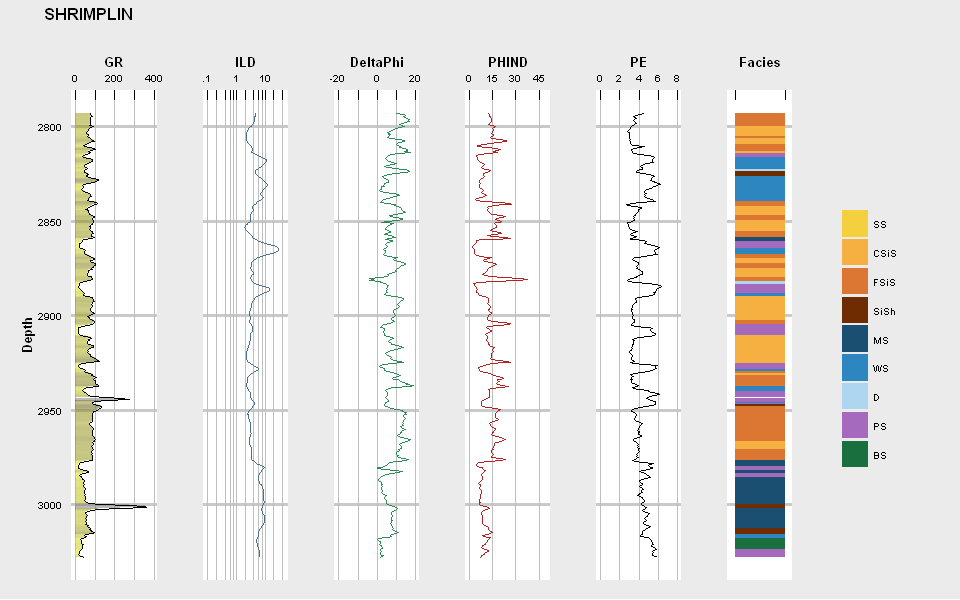

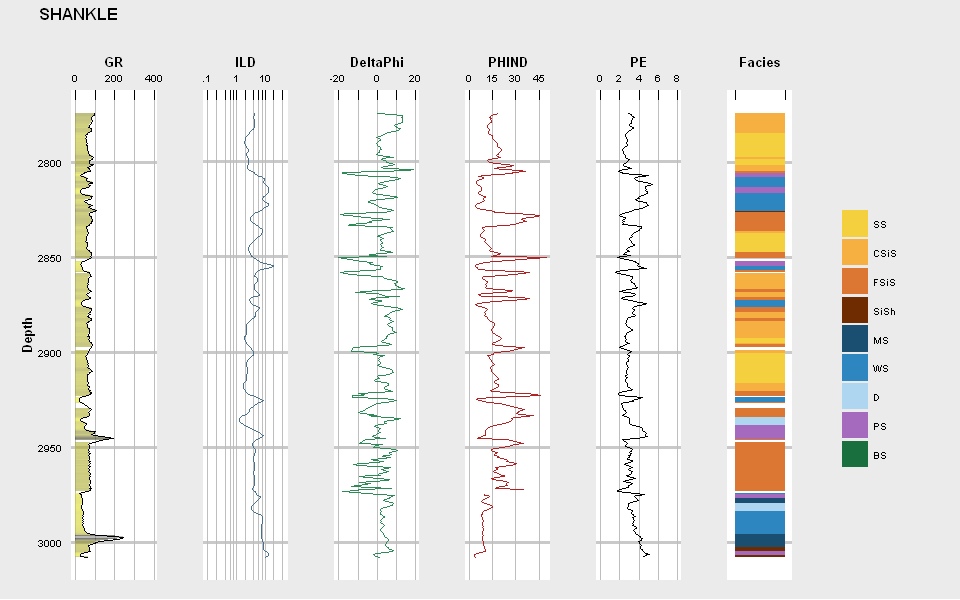

In [13]:
options(repr.plot.width=8, repr.plot.height=5)

# plot logs for the Shrimplin and Shankle wells
logplot(data[data$Well.Name == "SHRIMPLIN",])
logplot(data[data$Well.Name == "SHANKLE",])

We can also look at how the different facies are represented in the entire training data set.  Let's make a histogram!


  BS CSiS    D FSiS   MS   PS SiSh   SS   WS 
 130  640   82  535  189  442  126  259  366 

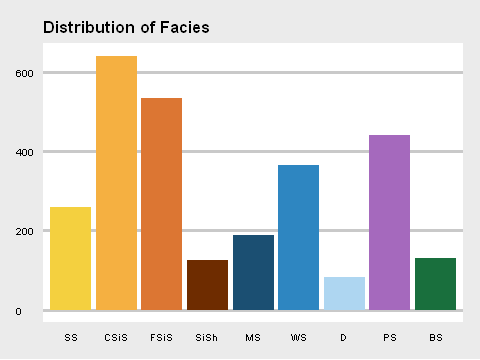

In [14]:
options(repr.plot.width=4, repr.plot.height=3)

table(facies_labels[data$Facies])

# build histogram of facies in training data
g <- ggplot(data) + theme_economist_white(gray_bg=T) +
    geom_bar(aes(x=Facies, fill=Facies)) + labs(title="Distribution of Facies", x="", y="") +
    scale_x_discrete(labels=facies_labels) +
    scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
    theme(legend.position="none", legend.title=element_blank(), legend.text=element_text(size=6),
         axis.text=element_text(size=6), plot.title=element_text(size=10), axis.title=element_blank(),
         axis.ticks.x=element_blank())
g

This shows the distribution of facies in the training data.  **Dolomite** (facies 7) has the fewest observations with 82; while **Marine Siltstone and Shale** (facies 4) and **Bafflestone** (facies 9) have 126 (second lowest) and 130 (third lowest) observations respectively.  Depending on the performance of the classifier we are going to train, we may consider acquiring more observations of these facies.  

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains five log variables, and a pairs plot can quickly visualize the variation between these five variables.

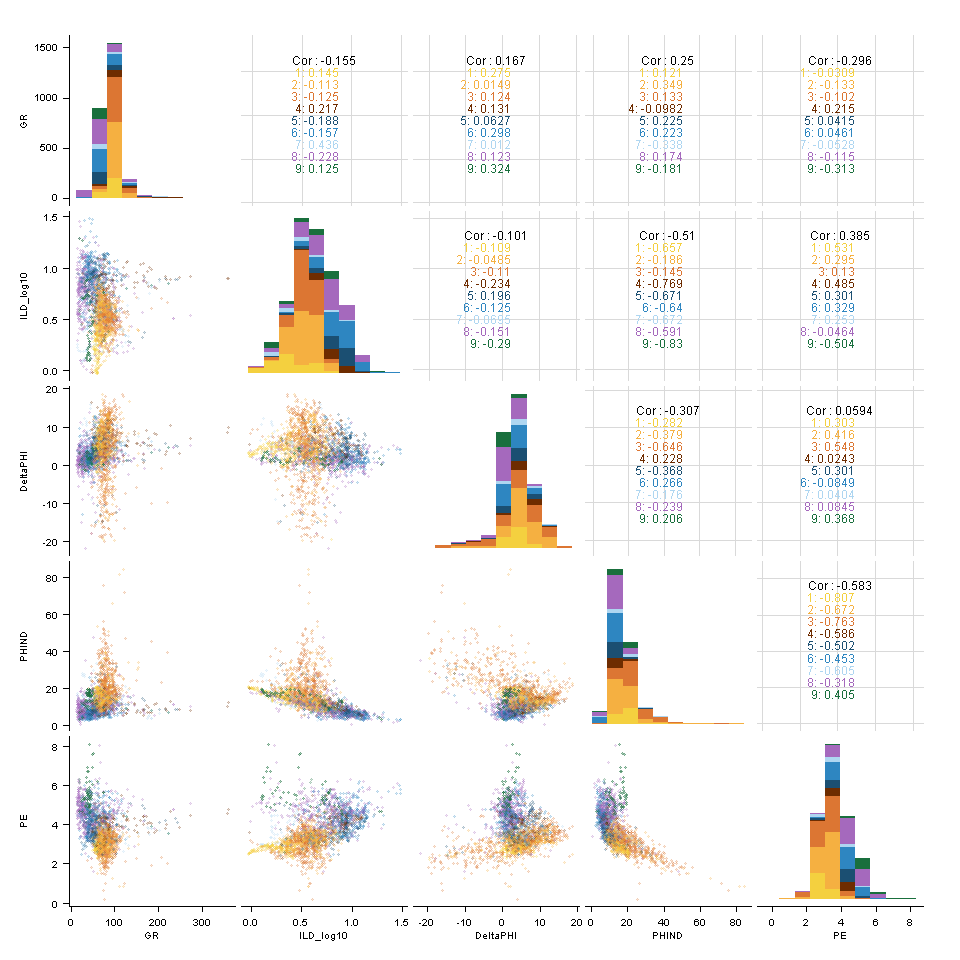

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

# build pairs plot
p <- ggpairs(data, aes(colour=Facies), columns=c("GR", "ILD_log10", "DeltaPHI", "PHIND", "PE"), 
             lower=list(continuous=wrap("points",size=.5,alpha=.2)),
             diag=list(continuous=wrap("barDiag",bins=10)), 
             upper=list(continuous=wrap("cor", size=2.5))) + 
            theme(axis.text=element_text(size=6), axis.title=element_text(size=6))

# modify colors to be consistent by looping through all plots 
for (i in 1:p$nrow) {
    for (j in 1:p$ncol) {
        p[i,j] <- p[i,j] + scale_color_manual(values=facies_colors, drop=F, labels=facies_labels) + 
                scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels)
    }
}

p

## Conditioning the data set  

Now we will extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables.  We also get a vector of the facies labels that correspond to each feature vector.

In [16]:
# build vector of actual values and data frame of features to be used in prediction
correct_facies_labels <- data$Facies
feature_vectors <- data[, c("GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M", "RELPOS")]
summary(feature_vectors)

       GR           ILD_log10           DeltaPHI           PHIND      
 Min.   : 13.25   Min.   :-0.02595   Min.   :-21.832   Min.   : 0.55  
 1st Qu.: 48.12   1st Qu.: 0.47986   1st Qu.:  1.211   1st Qu.: 8.45  
 Median : 66.91   Median : 0.62190   Median :  3.500   Median :12.34  
 Mean   : 67.04   Mean   : 0.63735   Mean   :  3.573   Mean   :13.79  
 3rd Qu.: 80.59   3rd Qu.: 0.81900   3rd Qu.:  6.400   3rd Qu.:16.80  
 Max.   :361.15   Max.   : 1.48000   Max.   : 18.600   Max.   :84.40  
       PE        NM_M         RELPOS     
 Min.   :0.200   1:1443   Min.   :0.010  
 1st Qu.:3.078   2:1326   1st Qu.:0.269  
 Median :3.500            Median :0.526  
 Mean   :3.717            Mean   :0.519  
 3rd Qu.:4.371            3rd Qu.:0.767  
 Max.   :8.094            Max.   :1.000  

**Preprocessing** standardizes the data giving each variable zero mean and unit variance.  This is often called *whitening*.  Many machine learning algorithms assume features will be standard normally distributed (i.e. Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input as a classifier (i.e. the validation and/or test data sets).  

Fortunately, R's **[caret](https://topepo.github.io/caret/)** package has a handy function for this task (**caret** is short for **C**lassification **A**nd **Re**gression **T**raining).  The **caret** package is a set of functions which streamlines the process for creating predictive models and contains tools for pre-processing, splitting, feature selection, model tuning (using resampling), and variable importance estimation.

In [17]:
# center and scale the data
preProcValues <- preProcess(feature_vectors, method=c("center", "scale"))

"Before whitening:"
head(feature_vectors)
"After whitening:"
head(predict(preProcValues, feature_vectors))

[1] "Before whitening:"

GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
77.45,0.664,9.9,11.915,4.6,1,1.000
78.26,0.661,14.2,12.565,4.1,1,0.979
79.05,0.658,14.8,13.050,3.6,1,0.957
86.10,0.655,13.9,13.115,3.5,1,0.936
74.58,0.647,13.5,13.300,3.4,1,0.915
73.97,0.636,14.0,13.385,3.6,1,0.894


[1] "After whitening:"

GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0.3438151,0.106199476,1.200342,-0.23463270,0.9352388,1,1.675433
0.3705651,0.094243250,2.016165,-0.15346042,0.4055346,1,1.602290
0.3966546,0.082287025,2.130001,-0.09289341,-0.1241696,1,1.525662
0.6294786,0.070330799,1.959248,-0.08477618,-0.2301105,1,1.452519
0.2490342,0.038447530,1.883357,-0.06167330,-0.3360513,1,1.379375
0.2288892,-0.005391964,1.978220,-0.05105846,-0.1241696,1,1.306231


**caret** also includes useful functions to randomly (or not so randomly if you so choose) split the data into training and test data sets.  The test set contains a small subset of features which are not used for training (building the predictive model).  Since we know the actual facies values for these observations, we can compare our predicted results against the actual results to determine the accuracy of our model.  For this example, we will use 20% of the data.  It's worth noting that **caret** is clever enough such that the random sampling occurs within each facies class - preserving the overall facies distribution (recall the histogram above).

We'll be using the **e1071** package to fit an SVM (support vector machine) model to the data.  By default, the algorithm internally centers and scales the data to zero mean and unit variance.  So we can input the *before whitening* data into the algorithm.

In [18]:
set.seed(1234)

# split into training and test data sets
trainIndex <- createDataPartition(data$Facies, p=.8, list=F, times=1)
feature_vectors$Facies <- correct_facies_labels

x_train <- feature_vectors[trainIndex,]
x_test <- feature_vectors[-trainIndex,]
head(x_train)

GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
77.45,0.664,9.9,11.915,4.6,1,1.000,3
78.26,0.661,14.2,12.565,4.1,1,0.979,3
79.05,0.658,14.8,13.050,3.6,1,0.957,3
86.10,0.655,13.9,13.115,3.5,1,0.936,3
74.58,0.647,13.5,13.300,3.4,1,0.915,3
73.97,0.636,14.0,13.385,3.6,1,0.894,3


## Training the SVM classifier  

Now we will use the cleaned and conditioned training data to create a predictive facies classifier.  We will use the SVM (Support Vector Machine) machine learning algorithm which is a map of the feature vectors as points in high-dimensional space.  They are mapped such that the examples from different facies classes are divided by a clear gap that is as wide as possible.  

The **caret** package utilizes the **e1071** package as it's support vector machine algorithm.  Rather than use it through **caret**, we'll use **e1071** directly and use **caret** for analysis.  To maintain consistency with the Python version of this notebook by Brendan Hall, we'll use a *radial* kernel for our SVM model building.

In [38]:
# train the model using default svm settings
svmFit <- svm(Facies ~ ., data=x_train, kernel='radial')

# predict the facies
predictions <- predict(svmFit, newdata=x_test)

# function to display a confusion matrix
#   replaces the integer facies with facies shortnames first
disp_cm <- function(cm) {
    dimnames(cm)$Prediction <- facies_labels
    dimnames(cm)$Reference <- facies_labels
    print(cm)
}

In [39]:
# display the confusion matrix to evaluate the model
cm <- confusionMatrix(predictions, x_test$Facies)
cm_table <- as.matrix(cm[["table"]])

"Confusion matrix:"
disp_cm(cm_table)

[1] "Confusion matrix:"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS   29    5    1    0  0  1  0  0  0
      CSiS 21   80   24    0  2  0  0  0  0
      FSiS  1   43   79    0  1  0  1  5  0
      SiSh  0    0    0    9  0  1  1  0  0
      MS    0    0    0    2  2  1  2  1  0
      WS    0    0    0   11 23 55  1 18  0
      D     0    0    0    1  0  0  6  1  0
      PS    0    0    3    2  9 15  4 61 10
      BS    0    0    0    0  0  0  1  2 16


The rows of the confusion matrix correspond to the predicted facies labels; while, the columns correspond to the actual facies labels.  For example, consider the first row, for feature vectors in the test data that actually have a facies label of 'SS' (facies 1), 51 observations, 29 were correctly classfied as SS, 21 were classified as CSis, and 1 was identified as FSiS.  

The confusion matrix diagonal represents facies that were correctly identified.  Below we calculate two accuracy metrics to evaluate how the algorithm is performing: one for identifying the facies correctly, and a second for identifying the facies either correctly, or as one of the adjacent facies (due to the gradational nature of facies).  Accuracy here is defined as the number of correct classification (either absolute, or absolute+adjacent) divided by the total number of classifications.

In [118]:
# list of adjacent facies
adjacent_facies <- list(as.list(c(2)), as.list(c(1,3)), 
                        as.list(c(2)), as.list(c(5)), 
                        as.list(c(4,6)), as.list(c(5,7,8)), 
                        as.list(c(6,8)), as.list(c(6,7,9)), 
                        as.list(c(7,8)))

# function to calculate the confusion matrix which includes adjacent facies as correctly classified
adj_cm_table <- function(cm_table) {    
    adj_cm_table <- cm_table
    
    # loop through facies to build adjacent facies confusion matrix
    for (i in 1:9) {
        cor <- cm_table[i,i]

        # move adjacently correct facies into correct facies
        for (j in 1:length(adjacent_facies[[i]])) {
            cor <- cor + cm_table[adjacent_facies[[i]][[j]],i]
            adj_cm_table[adjacent_facies[[i]][[j]],i] <- 0
        }
        adj_cm_table[i,i] <- cor
    }
    
    # return adjacently corrected confusion matrix
    adj_cm_table
}

In [41]:
# facies classification accuracy
paste("Facies classification accuracy:", round(cm[["overall"]][1],2))

# adjacent facies classification accuracy
adj <- adj_cm_table(cm_table)
paste("Adjacent facies classification accuracy:", round(sum(diag(adj)) / sum(adj),2))

[1] "Facies classification accuracy: 0.61"

[1] "Adjacent facies classification accuracy: 0.92"

These values are approximately equal to Brendon Hall's results of 0.63 and 0.93 respectively.  The original tutorial by Brendan Hall used *Precision*, *Recall*, and *F1-Score* to evaluate the accuracy of the predictive model.  Let's calculate and output these.

In [117]:
# cm - confusion matrix either as a confusionMatrix object or table object
# x - the data used, from this we calculate how many observations (support) for each facies
accuracy_metrics <- function(cm, x) {
    # if given confusion matrix (cm) is a confusionMatrix object
    if (class(cm) == "confusionMatrix") {
        df <- data.frame("Facies" = facies_labels,
                        "Precision" = cm[["byClass"]][,5],
                        "Recall" = cm[["byClass"]][,6],
                        "F1" = cm[["byClass"]][,7],
                        "Support" = as.matrix(table(x$Facies)))
        df[,-1] <- round(df[,-1],2)
        rownames(df) <- NULL
    }
    # if given confusion matrix is a table object
    else if (class(cm) == "table") {
       # initialize vectors for precision, recall, and f1 metrics with zeros
        prec <- rep(0,9)
        recall <- rep(0,9)
        f1 <- rep(0,9)

        # loop through facies to compute precision, recall, and f1 for each facies
        beta <- 1
        for (i in 1:9) {
            prec[i] <- cm[i,i] / sum(cm[i,])
            recall[i] <- cm[i,i] / sum(cm[,i])
            f1[i] <- (1 + beta^2) * prec[i] * recall[i] / ((beta^2 * prec[i]) + recall[i])
        }
        
        # calculate model metrics for precision, recall, and f1 and output
        df <- data.frame(Facies=facies_labels, 
                         Precision=prec, 
                         Recall=recall, 
                         F1=f1, 
                         Support=as.matrix(table(x$Facies)))

        # round values to two digits
        df[,-1] <- round(df[,-1],2)
    }
    
    # average F1 score across all classes
    print(paste0("Overall F1-score of: ", round(mean(df$F1, na.rm=T),2)))
    print("Accuracy metrics:")
    df
}

In [111]:
# compute and display accuracy metrics
accuracy_metrics(cm, x_test)

[1] "Overall F1-score of: 0.56"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,0.81,0.57,0.67,51
CSiS,0.63,0.62,0.63,128
FSiS,0.61,0.74,0.67,107
SiSh,0.82,0.36,0.50,25
MS,0.25,0.05,0.09,37
WS,0.51,0.75,0.61,73
D,0.75,0.38,0.50,16
PS,0.59,0.69,0.64,88
BS,0.84,0.62,0.71,26


## Model parameter selection  

With exception to defining the algorithm, the model so far has been built with the default parameters.  It may be possible to improve the classification results by optimizing these parameter choices.  

We will consider two parameters, **C** cost which is a regularization factor telling the classifier how much we want to avoid misclassifying training examples, and **gamma** which describes the size of the radial basis functions (how far away two vectors in space need to be to be considered close).  

A large **C** will try to correctly classify more examples from the training set at the potential cost of "overfitting" - and failing to generalize when classifying new data.  

We will train a grid of classifiers with different values for **C** and **gamma**, recording the classification accuracies along the way.  This process is often referred to as *cross validation*.  Often a separate *cross validation* dataset will be created in addition to the training and test sets in order to perform model selection.  For this tutorial, we will simply use the test set to choose model parameters.

In [25]:
set.seed(3124)

# calculates models for a variety of hyperparameters - this will take a few minutes
tune.out <- tune(svm, Facies ~ ., data=x_train, 
                 kernel="radial",
                 ranges=list(cost=c(.01,1,5,10,20,50,100,1000,5000,10000),
                            gamma=c(.0001,.001,.01,1,10)))
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
   10     1

- best performance: 0.2475297 

- Detailed performance results:
    cost gamma     error dispersion
1  1e-02 1e-04 0.7691717 0.01797716
2  1e+00 1e-04 0.7691717 0.01797716
3  5e+00 1e-04 0.6217480 0.02030579
4  1e+01 1e-04 0.5992010 0.02754936
5  2e+01 1e-04 0.5514043 0.02674555
6  5e+01 1e-04 0.5130773 0.03158356
7  1e+02 1e-04 0.4634870 0.02967761
8  1e+03 1e-04 0.4148078 0.03386588
9  5e+03 1e-04 0.4148058 0.02971705
10 1e+04 1e-04 0.4139008 0.02964042
11 1e-02 1e-03 0.7691717 0.01797716
12 1e+00 1e-03 0.5996515 0.02766592
13 5e+00 1e-03 0.5117260 0.03343920
14 1e+01 1e-03 0.4634870 0.02898585
15 2e+01 1e-03 0.4387000 0.02650699
16 5e+01 1e-03 0.4224695 0.03076736
17 1e+02 1e-03 0.4116485 0.03321039
18 1e+03 1e-03 0.4030696 0.03061760
19 5e+03 1e-03 0.3895398 0.02728369
20 1e+04 1e-03 0.3841323 0.03012470
21 1e-02 1e-02 0.7691717 0.01797716
22 1e+00 1e-02 0.4549203 

The summary of our tuning displays all combinations of **cost** and **gamma** along with the associated models' error and dispersion.  Conveniently, the model with the best performance is highlighted at the top displaying its hyperparameters and error.  

The best (lowest) error was achieved using **gamma** = 1, and **C** = 10.  This result is consistent with Brendan Hall's Python version of this analysis.  Now let's predict facies using this best model - and display its confusion matrix!

In [44]:
cv_predictions <- predict(tune.out$best.model, newdata=x_test)

# display the confusion matrix to evaluate the model
cv_cm <- confusionMatrix(cv_predictions, x_test$Facies)

"Confusion matrix:"
disp_cm(as.matrix(cv_cm[["table"]]))

[1] "Confusion matrix:"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS   40   11    0    0  0  0  0  0  0
      CSiS 10   95   18    0  1  1  1  0  0
      FSiS  1   22   87    1  0  0  0  5  0
      SiSh  0    0    2   17  1  5  0  0  0
      MS    0    0    0    2 24  3  0  1  0
      WS    0    0    0    2  6 59  2 10  0
      D     0    0    0    1  0  0  9  2  0
      PS    0    0    0    2  5  5  2 70  0
      BS    0    0    0    0  0  0  2  0 26


And a look at facies classification accuracy along with adjacent facies classification accuracy.

In [45]:
# facies classification accuracy
paste("Facies classification accuracy:", round(cv_cm[["overall"]][1],2))

# adjacent facies classification accuracy
cv_adj <- adj_cm_table(cv_cm_table)
paste("Adjacent facies classification accuracy:", round(sum(diag(cv_adj)) / sum(cv_adj),2))

[1] "Facies classification accuracy: 0.77"

[1] "Adjacent facies classification accuracy: 0.95"

Our facies classification accuracy and adjacent facies classification accuracy increased from 0.62 and 0.92 to 0.77 and 0.95 respectively!  This is consistent with Hall's 0.75 and 0.93 accuracies.  Precision and Recall are metrics that give more insight into how the classifier is performing for an individual facies.  Precision is the probability that given a classification prediction for an observation, that observation actually belongs to that facies class.  Recall is the probability that a smaple will be correctly classified for a given class.  Let's show them now!

In [112]:
# compute and display accuracy metrics
accuracy_metrics(cv_cm, x_test)

[1] "Overall F1-score of: 0.77"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,0.78,0.78,0.78,51
CSiS,0.75,0.74,0.75,128
FSiS,0.75,0.81,0.78,107
SiSh,0.68,0.68,0.68,25
MS,0.80,0.65,0.72,37
WS,0.75,0.81,0.78,73
D,0.75,0.56,0.64,16
PS,0.83,0.80,0.81,88
BS,0.93,1.00,0.96,26


To interpret these results, consider the facies SS.  In our test set, if a sample was labeled SS the probability the sample was correct is 0.78 (precision).  If we know a sample has facies SS, then the probability it will be correclty labeled by the classifier is 0.78 (recall).  It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases.  The **F1 score** combines both to give a single measure of relevancy of the classifiers results.  

These results can assist in guiding intuition for improving the classifications.  For example, the Facies D (dolomite) is only classified correctly 56% of the time (recall).  Perhaps this could be improved by introducing more training samples.  Sample quality could also play a role.  Facies BS (bafflestone) has the best **F1 score** despite relatively few training observations.  But this data was handpicked from other wells to provide training observations to identify this facies.  

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct.

In [113]:
# compute and display accuracy metrics
accuracy_metrics(cv_adj, x_test)

[1] "Overall F1-score of: 0.92"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,1.00,0.98,0.99,51
CSiS,0.98,1.00,0.99,128
FSiS,0.94,0.98,0.96,107
SiSh,0.73,0.76,0.75,25
MS,0.97,0.84,0.90,37
WS,0.97,0.92,0.94,73
D,0.93,0.81,0.87,16
PS,0.92,0.93,0.93,88
BS,0.93,1.00,0.96,26


The F1 scores for all facies types are high.  The model has the most difficulty with *SiSh - marine siltone and shale*, frequently misclassifying this facies (recall of 0.76).  These results are comparable to those reported in the Python version of this notebook by Brendan Hall.  Differences can be attributed to back-end implementations of the SVM algorithm and different random number seeds.

## Applying the classification model to the blind data  

Earlier, we held a single well **Newby** back from the training data set and stored it in a dataframe called *blind*.

In [48]:
# display first five rows of blind well data along with its dimensions
head(blind)
paste(dim(blind)[1], "rows x", dim(blind)[2], "columns")

,Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Predicted
3283,3,A1 SH,NEWBY,2826.0,76.34,0.719,7.8,11.00,3.7,1,1.000,3
3284,3,A1 SH,NEWBY,2826.5,83.74,0.688,9.7,12.55,3.4,1,0.977,3
3285,3,A1 SH,NEWBY,2827.0,83.19,0.664,10.1,11.95,3.4,1,0.953,3
3286,3,A1 SH,NEWBY,2827.5,80.44,0.648,10.1,11.15,3.4,1,0.930,3
3287,3,A1 SH,NEWBY,2828.0,75.42,0.648,9.3,11.45,3.3,1,0.907,3
3288,3,A1 SH,NEWBY,2828.5,71.50,0.663,9.2,11.60,3.3,1,0.884,3


[1] "463 rows x 12 columns"

In [114]:
# use the tuned svm model to predict facies on the blind data
y_pred <- predict(tune.out$best.model, newdata=blind[,c(-2,-3,-4)])
blind$Predicted <- y_pred
cv_cm_blind <- confusionMatrix(y_pred, blind$Facies)
cv_cm_blind_tbl <- as.matrix(cv_cm_blind[["table"]])

# display the confusion matrix
"Blind facies classification:"
disp_cm(cv_cm_blind_tbl)

# compute and display accuracy metrics
accuracy_metrics(cv_cm_blind, blind)

[1] "Blind facies classification:"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS    0   20    4    0  0  0  0  0  0
      CSiS  0   49   29    0  1  1  0  1  0
      FSiS  0   27   43    4  1  4  0  6  0
      SiSh  0    0    0   42  4  5  0  0  2
      MS    0    0    0    2  1 32  0  5  0
      WS    0    0    0    5  9 10  0  4  4
      D     0    0    0    0  0  0  0  2  0
      PS    0    2    4    5 12 42 16 38 25
      BS    0    0    0    0  0  2  0  0  0
[1] "Overall F1-score of: 0.4"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,0.00,NA,NA,0
CSiS,0.60,0.50,0.55,98
FSiS,0.51,0.54,0.52,80
SiSh,0.79,0.72,0.76,58
MS,0.02,0.04,0.03,28
WS,0.31,0.10,0.16,96
D,0.00,0.00,NaN,16
PS,0.26,0.68,0.38,56
BS,0.00,0.00,NaN,31


Our facies classifier has an overall score of **0.4**.  Now let's include adjacent facies as being correctly classified.

In [115]:
# compute adjacent confusion matrix
cv_cm_blind_adj <- adj_cm_table(cv_cm_blind_tbl)

# display confusion matrix
"Blind adjacent facies classification:"
disp_cm(cv_cm_blind_adj)

# compute and display accuracy metrics
accuracy_metrics(cv_cm_blind_adj, blind)

[1] "Blind adjacent facies classification:"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS    0    0    4    0  0  0  0  0  0
      CSiS  0   96    0    0  1  1  0  1  0
      FSiS  0    0   72    4  1  4  0  6  0
      SiSh  0    0    0   44  0  5  0  0  2
      MS    0    0    0    0 14  0  0  5  0
      WS    0    0    0    5  0 84  0  0  4
      D     0    0    0    0  0  0 16  0  0
      PS    0    2    4    5 12  0  0 44  0
      BS    0    0    0    0  0  2  0  0 25
[1] "Overall F1-score of: 0.84"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,0.00,NaN,NaN,0
CSiS,0.97,0.98,0.97,98
FSiS,0.83,0.90,0.86,80
SiSh,0.86,0.76,0.81,58
MS,0.74,0.50,0.60,28
WS,0.90,0.88,0.89,96
D,1.00,1.00,1.00,16
PS,0.66,0.79,0.72,56
BS,0.93,0.81,0.86,31


When including the adjacent facies as being correctly classified, our overall F1 score jumps to **0.84**.  This value (and the facies classifier F1 score of **0.4**) are in line with Brendan Hall's results in the Python version of this notebook.

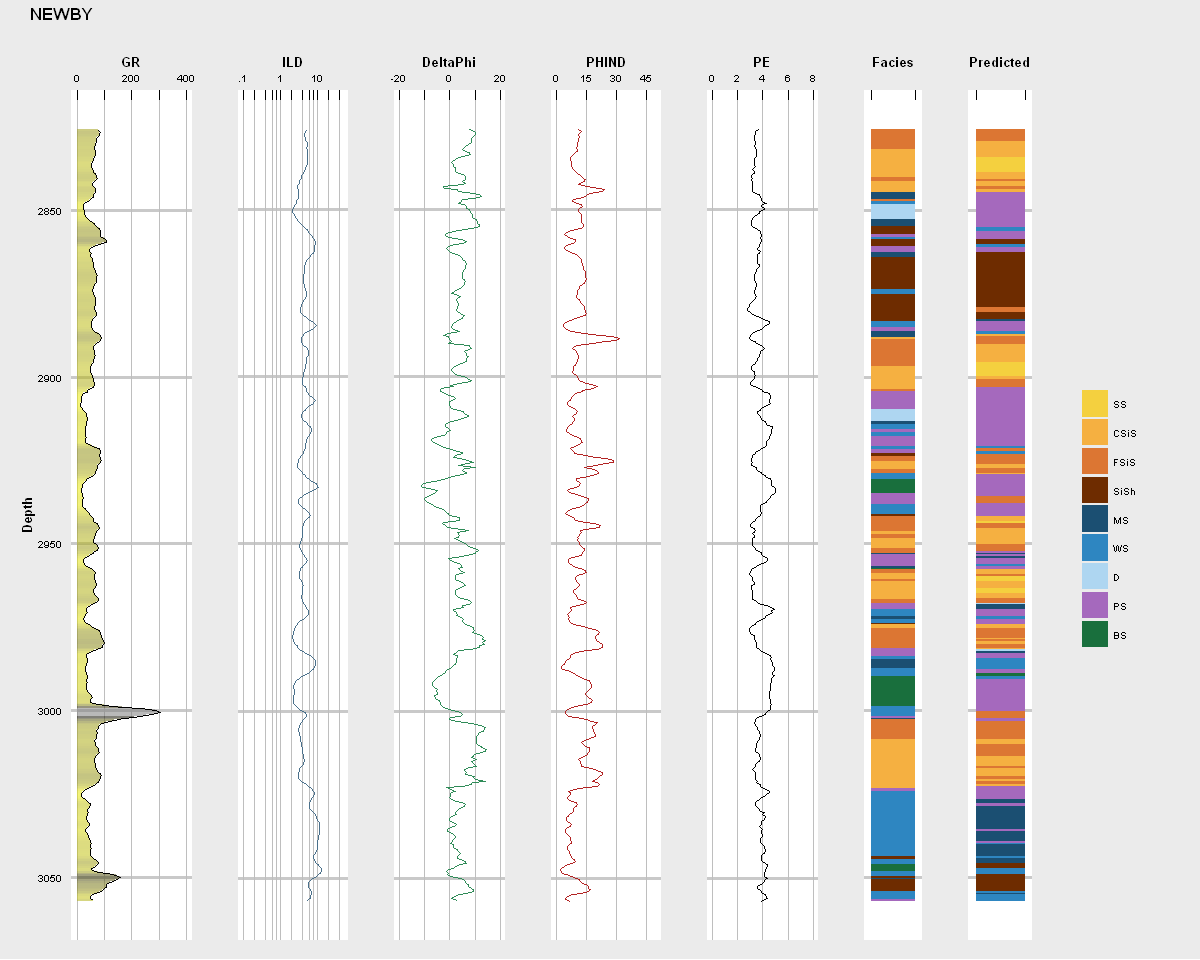

In [116]:
options(repr.plot.width=10, repr.plot.height=8)

# display logs and predicted facies
logplot(blind, TRUE, TRUE)

## Applying the classification model to new data  

Now that we have an optimized and trained classification model we can use it to identify facies in wells that do not have facies classifications.  In this case we will apply the classifier to two wells; however, we could apply it to any number of wells for which we have the same set of logs for input.  

This data set is similar to the training data except it does not have facies labels.  We'll load it into a data frame called *new_data*.

In [54]:
# load new data
fname <- "../validation_data_nofacies.csv"
new_data <- read.csv(fname, colClasses=c(rep("factor",2), rep("numeric",6), "factor", "numeric"))

# display five rows of new data and dimensions
head(new_data)
paste(dim(new_data)[1], "rows x", dim(new_data)[2], "columns")

Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911
A1 SH,STUART,2810.5,73.955,0.667,6.9,12.25,3.086,1,0.889


[1] "830 rows x 10 columns"

Now let's apply our classifier and print out the logs with predicted facies!

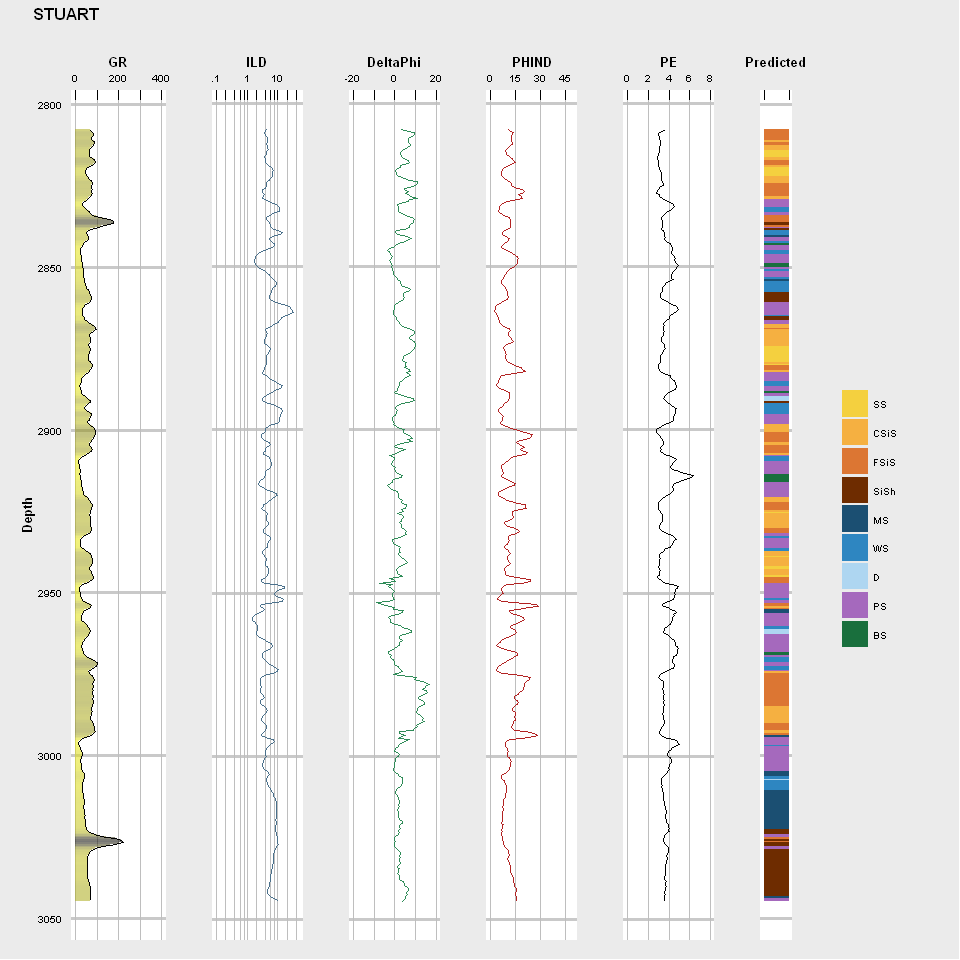

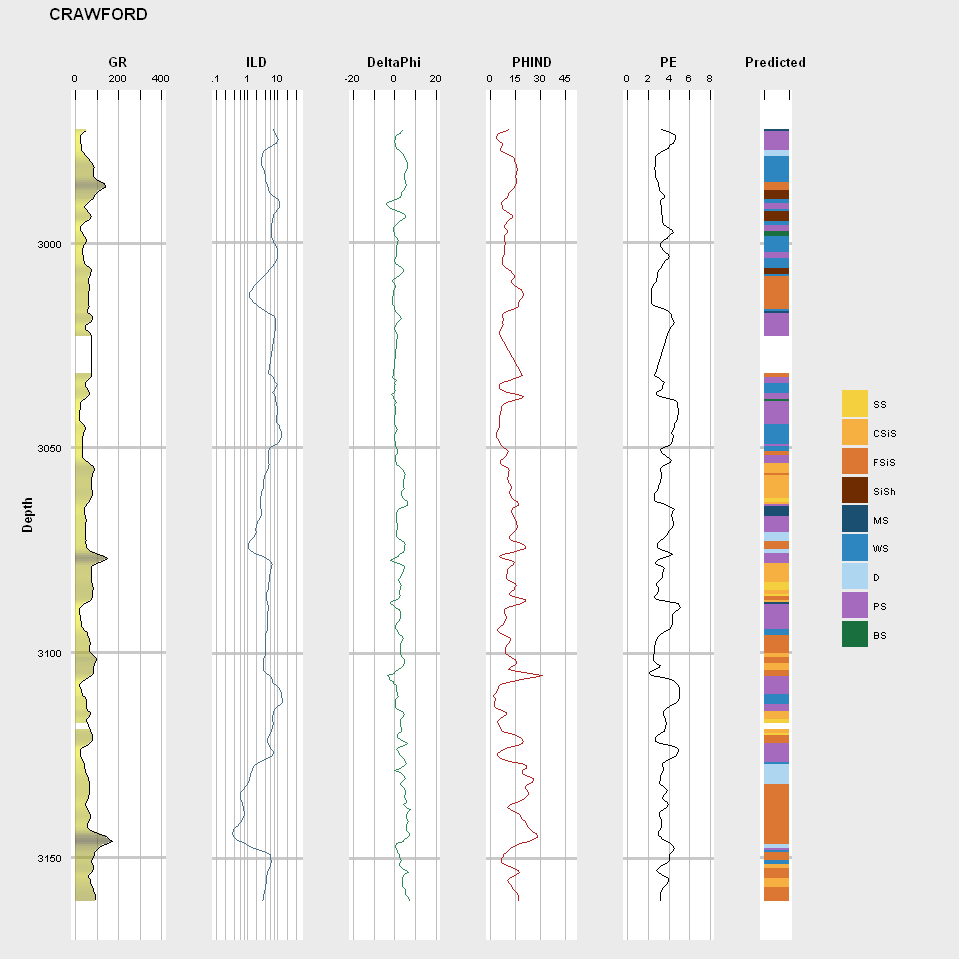

In [55]:
# predict facies
new_predict <- predict(tune.out$best.model, newdata=new_data[,c(-1,-2,-3)])
new_data$Predicted <- new_predict

# plot the logs!
logplot(new_data[new_data$Well.Name == "STUART",], FALSE, TRUE)
logplot(new_data[new_data$Well.Name == "CRAWFORD",], FALSE, TRUE)